In [8]:
# neural network that takes in four design variables from composites and outputs a predicted failure load

# ----------------------------------------------------
# INPUT
# [fiber type, fiber weight, dispersing agent, mixing]
# ----------------------------------------------------
# # fiber type
# ## 0 = PR
# ## 1 = OX
# ----------------------------------------------------
# # fiber weight
# ## .25 -> 1.00 in .25 increments
# ----------------------------------------------------
# # dispersing agent
# ## 0 = no
# ## 1 = yes
# ----------------------------------------------------
# # mixing
# ## 0 = SO
# ## 1 = HS
# ## 2 = HS + SO
# ----------------------------------------------------

In [9]:
# IMPORTS 
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [10]:
# Bring in data
df = pd.read_excel('Flex_Data.xlsx', usecols='B:E,G', skiprows=3)

print(df)

# one-hotify the data that is not numerical
df['Fiber\nType'] = df['Fiber\nType'].map({'PR':0, 'OX':1})
df['Dispersing\nAgent'] = df['Dispersing\nAgent'].map({'No':0, 'Yes':1})
df['Mixing'] = df['Mixing'].map({'SO':0, 'HS':1, 'SO+HS':2})

# rename the failure load column
df.rename(columns={'Unnamed: 6':'Initial Slope'}, inplace = True)

# create a train and test set from the data
train_df = df.sample(frac=1, random_state=2)
test_df = df.drop(train_df.index)

# create data set of the experimentally found Failure Load
train_labels = train_df.pop('Initial Slope')
test_labels = test_df.pop('Initial Slope')

# convert the pandas dataframes to numpy arrays
train_dataset = train_df.to_numpy() / 463.6
train_labels = train_labels.to_numpy() / 463.6

test_dataset = test_df.to_numpy() / 463.6
test_labels = test_labels.to_numpy() / 463.6

   Fiber\nType  Fiber\nWeight (phr) Dispersing\nAgent Mixing  Unnamed: 6
0           PR                 0.25                No     SO       323.9
1           PR                 0.25                No     SO       266.9
2           PR                 0.50                No     SO       231.2
3           PR                 0.50                No     SO       267.8
4           PR                 0.75                No     SO       342.5
..         ...                  ...               ...    ...         ...
91          OX                 0.50               Yes  SO+HS       306.9
92          OX                 0.75               Yes  SO+HS       253.6
93          OX                 0.75               Yes  SO+HS       333.6
94          OX                 1.00               Yes  SO+HS       206.2
95          OX                 1.00               Yes  SO+HS       173.4

[96 rows x 5 columns]


In [11]:
# Build model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh', input_shape=[4,]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# optimizer chosen for fitting the data
optimizer = tf.keras.optimizers.RMSprop(.001)
# optimizer = tf.keras.optimizers.Adam()

# compile the model and print a summary of the model
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [12]:
# define the epochs and train the model
EPOCHS = 10000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split=0.1,
  verbose=0)

In [13]:
# test the model on the test data that was set aside
test_predict = model.predict(test_dataset)

predicted = []
actual = []

with open('res/slop_0_res.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ANN prediction'])
    writer.writerow(['variables', 'actual', 'predicted'])

    for sample in range(len(test_labels)):
        
        actual.append(test_labels[sample])
        predicted.append(test_predict[sample])
        
        print(f"Test set actual: {test_labels[sample]}, Predicted: {test_predict[sample]}")
        writer.writerow([test_dataset[sample], test_labels[sample], test_predict[sample][0]])

Test set actual: 0.738783433994823, Predicted: [0.69596434]
Test set actual: 0.6518550474547022, Predicted: [0.7368451]
Test set actual: 0.850086281276963, Predicted: [0.949402]
Test set actual: 0.6164797238999137, Predicted: [0.605421]
Test set actual: 0.49547023295944775, Predicted: [0.65363514]
Test set actual: 0.6479723899913717, Predicted: [0.80044425]
Test set actual: 0.6078515962036238, Predicted: [0.5853928]
Test set actual: 0.8828731665228645, Predicted: [0.8260035]
Test set actual: 0.7400776531492667, Predicted: [0.8632678]
Test set actual: 0.7059965487489215, Predicted: [0.925669]
Test set actual: 0.833692838654012, Predicted: [0.86261916]
Test set actual: 0.8375754961173425, Predicted: [0.88597196]
Test set actual: 0.29723899913718727, Predicted: [0.49284685]
Test set actual: 0.7014667817083692, Predicted: [0.6791709]
Test set actual: 0.8462036238136325, Predicted: [0.600071]
Test set actual: 0.8654012079378774, Predicted: [0.8095157]
Test set actual: 0.7709232096635029, Pr

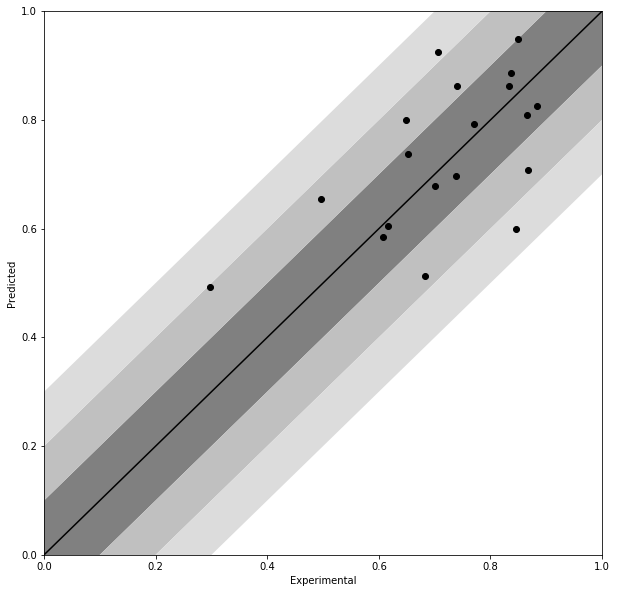

In [14]:
plt.figure(figsize=(10,10))

# 100% confidence
x = np.linspace(0,1,100)
y1 = x

plt.plot(x, y1, 'k-')

# 80% confidence interval
y2 = x + .1
y3 = x - .1

plt.fill_between(x, y1, y2,facecolor='grey')
plt.fill_between(x, y1, y3, facecolor='grey')

# 60% confidence interval
y4 = x + .2
y5 = x - .2

plt.fill_between(x, y2, y4, facecolor='silver')
plt.fill_between(x, y3, y5,facecolor='silver')

# 40% confidence interval
y6 = x + .3
y7 = x - .3

plt.fill_between(x, y4, y6, facecolor='gainsboro')
plt.fill_between(x, y5, y7, facecolor='gainsboro')

# plot results of NN
plt.plot(actual, predicted, 'ko')

plt.axis([0, 1, 0, 1])
plt.ylabel('Predicted')
plt.xlabel('Experimental')

plt.savefig('plots/slop_0_plot.png')
# plt.show()

